# 0.导包

In [1]:
import os
import gc
#数据处理
import pandas as pd
import numpy as np
import random
import sklearn.preprocessing as preprocessing
#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor, 
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

# 1.数据载入

In [14]:
# 需要5GB内存
feature_type = None
feature_type = (np.int64,np.int64,(np.str,60),(np.str,1990),np.int64,np.int64,np.int8,np.int8,np.int8,np.int8,np.int64,np.int8,np.int16,np.int16,np.int16,np.int64,np.int64,np.int16,(np.str,385),np.int64,np.int8,float,np.int16,float,float,float,np.int8)
data = pd.read_table('../2.data/round2_train.txt',sep = ' ',na_values = [-1.0,-1,'-1'])
print(data.shape)

data_test = pd.read_table('../2.data/round2_test_a.txt',sep = ' ',na_values = [-1.0,-1,'-1'])
data_test = pd.concat([
    data_test,
    pd.Series([0] * len(data_test),name = 'is_trade')
], axis = 1)
print(data_test.shape)

data = data.append(data_test)
del data_test
print(data.shape)

(10432036, 27)
(519888, 27)
(10951924, 27)


In [15]:
# 按时间排序，重置索引
data.reset_index(drop = True,inplace = True)
data.reset_index(inplace = True)
data.set_index('context_timestamp', drop = False,inplace=True)# f16转换为索引
data.sort_values(['context_timestamp'],inplace = True)

# 2.数据的基础特性

In [16]:
data.columns

Index(['index', 'instance_id', 'item_id', 'item_category_list',
       'item_property_list', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade'],
      dtype='object')

In [17]:
data.head()

,index,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,...,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade
context_timestamp,,,,,,,,,,,,,,,,,,,,,
1535644800,7375163,478270188272945727,5361917155737916091,836752724084922533;5685690139879409547;7497531...,6241534230954727302;2072967855524022579;513128...,3.678899e+18,1.962573e+17,8,9.0,11,...,4001,836752724084922533:9142827274221572643;5755694...,7585434829506891940,23,1.000000,5020,0.979675,0.981311,0.986869,0
1535644800,7302292,4528833136428437779,3796042518182063877,836752724084922533;7314150500379498593,7126426653086863522;2636395404473730413;462193...,1.429073e+18,5.326000e+18,4,11.0,11,...,4001,7314150500379498593:-1;8468370105908620354:-1;...,2200475787308907506,16,0.994742,5014,0.980822,0.981196,0.977126,0
1535644800,6833440,8464681986246001665,7492694414581985421,836752724084922533;8841625760168847319,5977512434884267894;2072967855524022579;263639...,3.435000e+18,1.962573e+17,6,12.0,13,...,4002,"836752724084922533:2636395404473730413,1877322...",234915890120973902,19,0.996153,5016,0.969655,0.969153,0.964311,0
1535644800,6541143,7238747585902785791,4457211666120969122,836752724084922533;7314150500379498593,143660112368942257;8070395809181082496;6710896...,4.660200e+18,5.326000e+18,6,12.0,14,...,4001,7314150500379498593:-1;836752724084922533:7080...,2583604515031986480,17,1.000000,5015,0.980195,0.980419,0.983445,0
1535644800,6670906,6736192758824389536,2348706058637303875,836752724084922533;1909641874861640857,6241534230954727302;367082587220462692;5977512...,1.975300e+18,6.219110e+18,7,9.0,11,...,4009,1036082357054043890:5131280576272319091;836752...,835127914526365821,17,1.000000,5015,0.963440,0.960271,0.979891,0


In [18]:
print(data.describe())
print(data.dtypes)

              index   instance_id       item_id  item_brand_id  item_city_id  \
count  1.095192e+07  1.095192e+07  1.095192e+07   1.052841e+07  1.094425e+07   
mean   5.475962e+06  4.611384e+18  4.645870e+18   5.040988e+18  4.268793e+18   
std    3.161548e+06  2.662949e+18  2.705609e+18   2.703190e+18  2.828945e+18   
min    0.000000e+00  4.404491e+11  2.926832e+13   6.721696e+14  3.534563e+16   
25%    2.737981e+06  2.304906e+18  2.281079e+18   2.596065e+18  1.019055e+18   
50%    5.475962e+06  4.610893e+18  4.676144e+18   5.373404e+18  5.161571e+18   
75%    8.213942e+06  6.918236e+18  7.040389e+18   7.838285e+18  6.219110e+18   
max    1.095192e+07  9.223372e+18  9.223092e+18   9.222764e+18  9.210156e+18   

       item_price_level  item_sales_level  item_collected_level  \
count      1.095192e+07      1.090607e+07          1.095192e+07   
mean       6.497764e+00      1.006125e+01          1.139212e+01   
std        1.317576e+00      2.683445e+00          2.541647e+00   
min        

In [21]:
data.isnull().sum()

index                             0
instance_id                       0
item_id                           0
item_category_list                0
item_property_list                4
item_brand_id                423516
item_city_id                   7673
item_price_level                  0
item_sales_level              45857
item_collected_level              0
item_pv_level                     0
user_id                           0
user_gender_id               281241
user_age_level                25706
user_occupation_id            25706
user_star_level               25706
context_id                        0
context_timestamp                 0
context_page_id                   0
predict_category_property       895
shop_id                           0
shop_review_num_level             0
shop_review_positive_rate       389
shop_star_level                   0
shop_score_service             1912
shop_score_delivery            1912
shop_score_description         1912
is_trade                    

In [20]:
data.isnull().sum()/len(data)

index                        0.000000e+00
instance_id                  0.000000e+00
item_id                      0.000000e+00
item_category_list           0.000000e+00
item_property_list           3.652326e-07
item_brand_id                3.867047e-02
item_city_id                 7.006075e-04
item_price_level             0.000000e+00
item_sales_level             4.187118e-03
item_collected_level         0.000000e+00
item_pv_level                0.000000e+00
user_id                      0.000000e+00
user_gender_id               2.567960e-02
user_age_level               2.347167e-03
user_occupation_id           2.347167e-03
user_star_level              2.347167e-03
context_id                   0.000000e+00
context_timestamp            0.000000e+00
context_page_id              0.000000e+00
predict_category_property    8.172080e-05
shop_id                      0.000000e+00
shop_review_num_level        0.000000e+00
shop_review_positive_rate    3.551887e-05
shop_star_level              0.000

**结论：**
1. 训练集中有前后七天的数据，测试集中有1天的数据。
2. 11个特征有缺失，详见属性意义.xls中标红的部分。
3. 属性范围：详见属性意义.xls

# 3.类型为list的属性（f2、f3、f18）的长度情况
## 3.1category_TRUE
### 3.1.1 2级、3级的个数

In [23]:
item_category_list_count = data.apply(lambda x:len(x['item_category_list'].split(';')),axis = 1)
print(item_category_list_count.value_counts())
gc.collect()
del item_category_list_count

- 2个category：6645464

- 3个category：4306460
### 3.1.2各个级别的取值统计

In [28]:
dic_one = {}
dic_two = {}
dic_three = {}

def func(x):
    now = x.split(';')
    if(now[0] not in dic_one):
        dic_one[now[0]] = 1
    else:
        dic_one[now[0]] += 1
        
    if(now[1] not in dic_two):
        dic_two[now[1]] = 1
    else:
        dic_two[now[1]] += 1
    
    if(len(now) == 3):
        if(now[2] not in dic_three):
            dic_three[now[2]] = 1
        else:
            dic_three[now[2]] += 1

In [35]:
dic_one

{'836752724084922533': 10951924}

In [34]:
dic_two

{'1147074168968532252': 76514,
 '1367177154073382718': 34601,
 '1852600517265062354': 515093,
 '1909641874861640857': 895856,
 '1916390345133212703': 264425,
 '1920084168104334820': 14922,
 '2211060154630359130': 386265,
 '2871729383671301763': 803148,
 '3089254302947620489': 53840,
 '3348197449185791127': 156980,
 '3434689896486063330': 334166,
 '3613783563199627217': 1268683,
 '394915394741096735': 69366,
 '453525480366550911': 540336,
 '4911723539855588624': 395018,
 '5066527928272238333': 114959,
 '5685690139879409547': 753891,
 '597424223456586363': 22152,
 '6254910033820815248': 1572,
 '6670526099037031245': 721143,
 '6693726201323251689': 478990,
 '7226013370341271704': 75051,
 '7314150500379498593': 447099,
 '7423553047267511438': 27448,
 '768579787521575291': 1441549,
 '8009556227083201357': 110575,
 '8468007938333142982': 24562,
 '8468370105908620354': 117708,
 '8769426218101861255': 44460,
 '8841625760168847319': 757348,
 '926205401302902289': 4204}

In [36]:
dic_three

{'1036082357054043890': 779324,
 '1211218747418350392': 24445,
 '1467870729316566837': 81,
 '1477337614002467815': 2057,
 '1495388799908940789': 17748,
 '1518916302398149448': 24,
 '1648445715268836954': 86113,
 '1773757399237042247': 18707,
 '2066714603291850185': 8490,
 '2104555450664741842': 39386,
 '2191908169494844354': 390,
 '2394261830557757570': 7712,
 '242926926543588023': 498,
 '2633274017530890587': 2181,
 '3035072468277339626': 307551,
 '3056172284875068614': 294,
 '3123955557674420771': 26615,
 '3124898744105967967': 5841,
 '3492642177859571113': 595320,
 '367136320586454083': 90,
 '3876693557918392475': 55089,
 '4039562740693964315': 113,
 '4332449207759411579': 16375,
 '4423756922475142608': 1631,
 '4521717672641793229': 48136,
 '4559837827486289562': 19113,
 '4620042370703789850': 38335,
 '4642777236640081537': 19736,
 '4782940324184008212': 429,
 '4919080589661354708': 37465,
 '4993377953084092565': 25260,
 '5031957903352580938': 3685,
 '5103300281712296962': 287,
 '55

## 3.2property_TRUE

In [73]:
dic_pro_pre = {}

def func(x):
    try:
        for prop in x['item_property_list'].split(';'):
            if(prop in dic_pro_pre):
                dic_pro_pre[prop] += 1
            else:
                dic_pro_pre[prop] = 1
        return len(x['item_property_list'].split(';'))
    except:
        return np.nan
item_property_list_count = data.apply(func,axis = 1)
print(item_property_list_count.value_counts())
gc.collect()

23.0     770227
24.0     723208
22.0     715894
25.0     706806
26.0     635635
21.0     602566
27.0     554576
20.0     501824
28.0     409317
19.0     368354
29.0     339282
30.0     324924
31.0     281423
32.0     258538
33.0     244381
18.0     232077
35.0     198648
34.0     189071
37.0     186189
36.0     185981
38.0     166659
43.0     158566
17.0     145751
42.0     130182
16.0     130141
41.0     128670
40.0     120764
44.0     108230
39.0     107287
15.0      99963
          ...  
7.0        7110
79.0       6755
5.0        5957
80.0       4572
84.0       4317
99.0       4311
4.0        4049
90.0       3987
75.0       3950
88.0       3215
6.0        3170
3.0        2500
85.0       2464
93.0       2070
2.0        1936
103.0      1380
94.0       1329
81.0       1280
91.0       1260
86.0       1233
1.0         973
87.0        782
101.0       252
95.0        242
96.0        206
100.0       143
105.0       115
98.0        114
92.0         53
104.0        47
Length: 103, dtype: int6

185

In [74]:
dic_pro_pre

{'6241534230954727302': 5449311,
 '2072967855524022579': 5619648,
 '5131280576272319091': 2816499,
 '4067341101015777832': 2815305,
 '1243768796732904674': 3557746,
 '7839592306500064003': 3048421,
 '8399888477341455089': 3811257,
 '9142827274221572643': 49311,
 '7720067047352333360': 247674,
 '2032595807574745346': 2043034,
 '3990890173174293012': 49315,
 '360508730875480086': 2390993,
 '3036697890002945576': 30655,
 '6767866865334241642': 268921,
 '5512096939518377359': 2509659,
 '6972974632358979335': 5254002,
 '5103206280374780290': 2991036,
 '1222811227890998716': 531476,
 '1632071272960903698': 2232594,
 '7641965736702676165': 5645703,
 '5021444594183920564': 296281,
 '9037211532323157242': 1226,
 '4969439333471645763': 1876384,
 '7610260342785918417': 82320,
 '7126426653086863522': 120221,
 '2636395404473730413': 4464020,
 '4621934203383159480': 2386945,
 '3657871859501171040': 2303442,
 '1783098593778410609': 6060,
 '2886347676380617486': 2769037,
 '1715655600520899987': 6400,


## 3.3categroy and property_PREDICT

### 3.3.1category的取值个数

In [65]:
dic_cat_pre = {} # 总体记录

def func(x):
    try:
        for cat in x.split(';'):
            if(cat.split(':')[0] in dic_cat_pre):
                dic_cat_pre[cat.split(':')[0]] += 1
            else:
                dic_cat_pre[cat.split(':')[0]] = 1
        return len(x.split(';')) 
    except:
        return 0

predict_cat_count = data['predict_category_property'].apply(func) # 每条记录

In [66]:
predict_cat_count.value_counts()

4     2283463
3     2161558
2     2150060
5     1724684
6     1142884
7      636807
1      507997
8      255025
9       61082
10      18489
11       6709
12       1444
0         895
13        384
14        215
15        192
16         29
17          6
18          1
Name: predict_category_property, dtype: int64

In [67]:
dic_cat_pre,len(dic_cat_pre)

({'836752724084922533': 10748822,
  '5755694407684602296': 53414,
  '7908382889764677758': 129137,
  '7314150500379498593': 824377,
  '8468370105908620354': 266299,
  '768579787521575291': 1769639,
  '1916390345133212703': 746839,
  '1036082357054043890': 1892288,
  '1094549894078844117': 91539,
  '6053399217025158422': 539886,
  '8096917686185033019': 600702,
  '8826467575698439758': 335741,
  '7497531498747093265': 881600,
  '1852600517265062354': 1205651,
  '3613783563199627217': 389148,
  '6670526099037031245': 1962101,
  '3492642177859571113': 1079290,
  '4521717672641793229': 280494,
  '4911723539855588624': 606188,
  '1909641874861640857': 1690265,
  '8841625760168847319': 1091282,
  '7848078693615386447': 611206,
  '3876693557918392475': 346963,
  '2211060154630359130': 78678,
  '3512965629309825317': 196838,
  '5170466750387851383': 574598,
  '2060242334325730925': 127280,
  '4332449207759411579': 64448,
  '4919080589661354708': 97899,
  '6370392357088946840': 654229,
  '80774

### 3.3.2property的取值个数

In [69]:
dic_pro_pre = {} # 总体记录
def func(x):
    res = 0
    try:
        for cat in x.split(';'):
            res += len(cat.split(':')[1].split(','))
            for prop in cat.split(':')[1].split(','):
                if(prop in dic_pro_pre):
                    dic_pro_pre[prop] += 1
                else:
                    dic_pro_pre[prop] = 1
    except:
        print(x)
    return res
predict_cat_count = data['predict_category_property'].apply(func) # 每条记录

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [70]:
predict_cat_count.value_counts()

4     1509966
5     1344806
6     1270267
7     1081326
3      927796
8      919620
9      734560
10     702536
11     688827
2      629539
12     562974
13     329035
1      131022
14     101248
15      15610
16       1869
0         895
17         27
18          1
Name: predict_category_property, dtype: int64

In [71]:
dic_pro_pre,len(dic_pro_pre)

({'9142827274221572643': 236523,
  '-1': 21106664,
  '8218883658021718578': 1582302,
  '3110677345556441261': 1104732,
  '2636395404473730413': 7627268,
  '18773227022480660': 2035479,
  '8560457883563738697': 178832,
  '7070153948098681983': 1860675,
  '8148626172083066849': 297226,
  '2886347676380617486': 498881,
  '6491818071284064879': 1771464,
  '5977512434884267894': 244970,
  '3540471119339706981': 2075502,
  '6241534230954727302': 652039,
  '708017611294974673': 235726,
  '3480876984427839465': 258733,
  '9011444777478954178': 771194,
  '5103206280374780290': 709787,
  '5131280576272319091': 4674657,
  '5544396398274366723': 516703,
  '367082587220462692': 497520,
  '820647477041419307': 716494,
  '6972974632358979335': 319549,
  '7557400419871705925': 53190,
  '8689439327673289769': 337886,
  '7145278029856447358': 68656,
  '7720067047352333360': 83517,
  '4195997301391045944': 1126049,
  '6130382903123134343': 4420,
  '4110591369872703088': 1537222,
  '3240681216445118729': 

**结论：**
1. f2（2-3）:2：476109，3：2029  
2. f3（6-68\70-76\82\85\88\89\91\93\97\99\100）:22: 6710, 50: 4150, 46: 7329, 30: 24263, 32: 26909, 35: 25825, 33: 32624, 48: 7321, 29: 20850, 39: 17307, 25: 18059, 37: 17706, 24: 8226, 34: 25928, 27: 20681, 59: 717, 26: 15638, 43: 7616, 20: 4071, 21: 6394, 28: 17775, 17: 1675, 41: 10673, 13: 421, 19: 4295, 38: 17524, 23: 9229, 45: 5092, 36: 17916, 49: 9777, 51: 2052, 31: 27089, 44: 9863, 16: 1226, 18: 2291, 40: 12930, 15: 1075, 14: 437, 64: 35, 55: 285, 42: 8194, 47: 5955, 57: 280, 10: 63, 12: 379, 100: 3083, 54: 566, 76: 842, 52: 2320, 63: 741, 6: 2, 53: 1227, 60: 135, 71: 1053, 62: 145, 58: 795, 67: 73, 56: 162, 61: 655, 68: 63, 11: 151, 88: 656, 97: 13, 73: 1, 75: 3, 85: 20, 82: 64, 89: 22, 9: 87, 70: 125, 8: 17, 93: 9, 66: 23, 91: 82, 7: 10, 72: 6, 65: 12, 74: 79, 99: 41  
3. f18（1-28）:5: 97265, 2: 48734, 3: 69408, 6: 78767, 4: 98158, 7: 51378, 8: 18368, 1: 1516, 10: 4003, 9: 10354, 11: 137, 13: 18, 12: 31, 14: 1

# 4.画图展示

## 4.1特征与标签线性关系

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


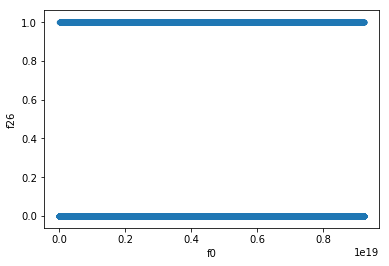

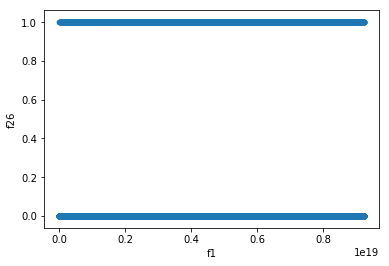

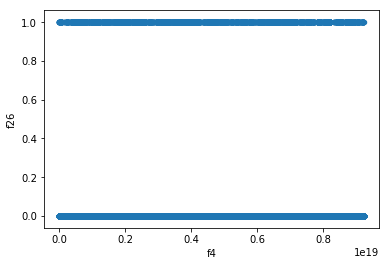

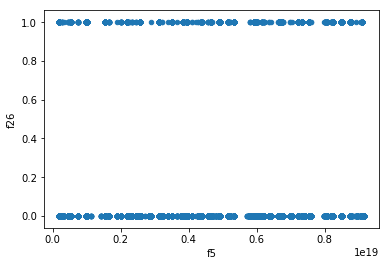

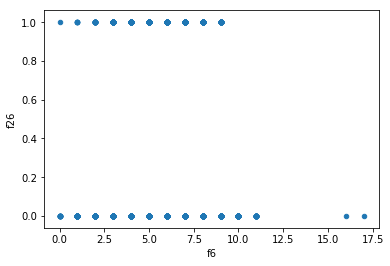

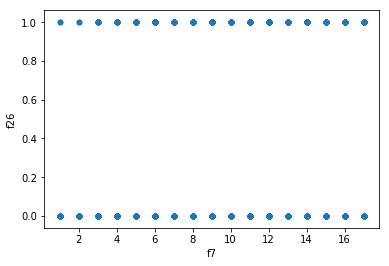

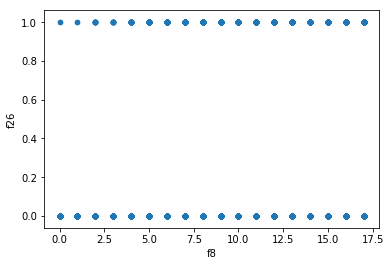

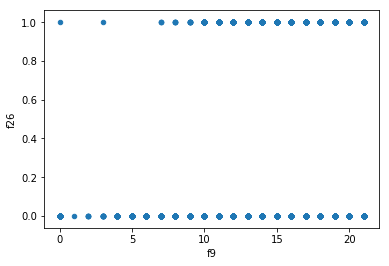

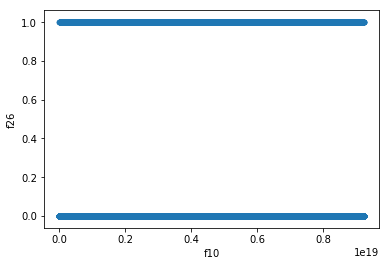

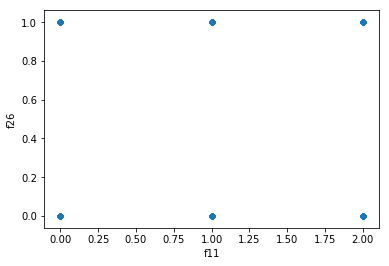

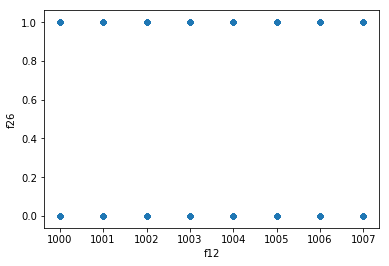

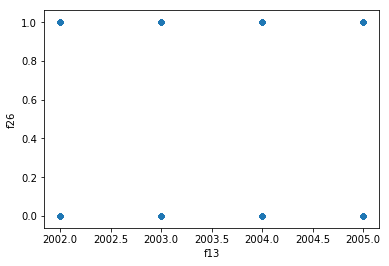

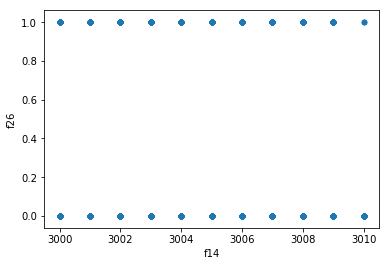

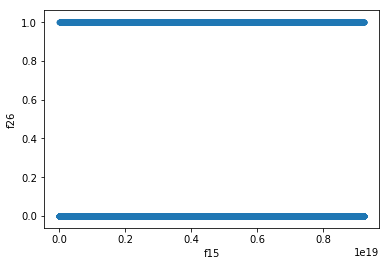

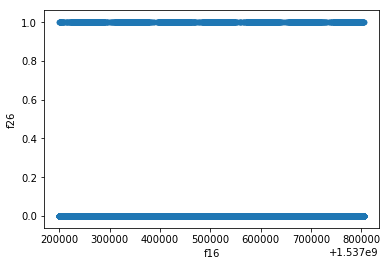

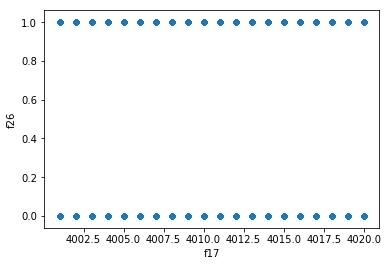

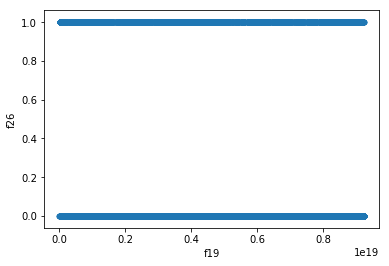

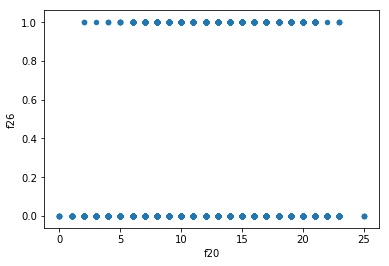

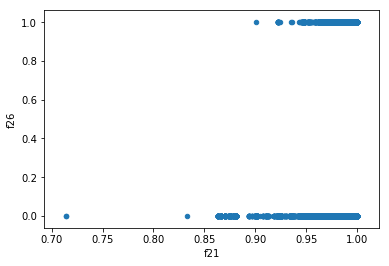

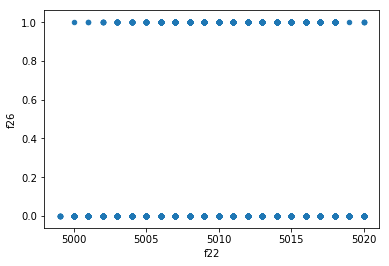

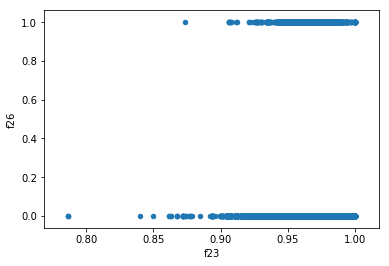

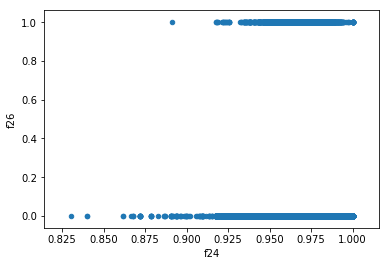

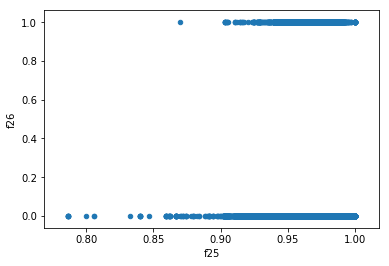

In [11]:
for i in range(26):
    if(i == 2 or i == 3 or i == 18):
        continue
    data_now = pd.concat([data['f' + str(i)], data['f26']], axis=1)
    data_now.plot.scatter(x='f' + str(i), y='f26')

结论：f6、f9、f20、f21、f22、f23、f24、f25、与最终结果**可能**有线性关系

## 4.2训练数据标签分布

In [6]:
data['f26'].sum()/len(data)

0.01886693799697995

**结论：**相当不平衡，只有1.89%的正样本数据

## 4.3训练数据特征分布

In [7]:
res_range = []
for i in range(27):
    if(i == 2 or i == 3 or i == 18):
        continue
    res_range.append(data.describe()['f' + str(i)][7] - data.describe()['f' + str(i)][3])   
print(res_range)

[9.2233582693159322e+18, 9.2212838998872003e+18, 9.2208769284074209e+18, 8.9550132323298202e+18, 17.0, 16.0, 17.0, 21.0, 9.2233204879549778e+18, 2.0, 7.0, 3.0, 10.0, 9.2233699228437443e+18, 604786.0, 19.0, 9.2192298060124908e+18, 25.0, 0.2857142857142857, 21.0, 0.21333333333333337, 0.16999999999999993, 0.21333333333333337, 1.0]


In [9]:
%matplotlib inline

fig = plt.figure(figsize = (400, 100))
for i in range(26):
    if(i == 2 or i == 3 or i == 18):
        continue
    plt.subplot(4,7,i+ 1)
    plt.hist(data['f' + str(i)].dropna(), bins = 100, color='steelblue', normed=True )


**结论：**
1. f6、f7、f8、f9、f12、f16、f17、f20、f22、f23、f24、f25有明显分布，f13、f14、f21有欠明显分布
2. 都不怎么均衡，需要后期再处理

## 4.4盒图

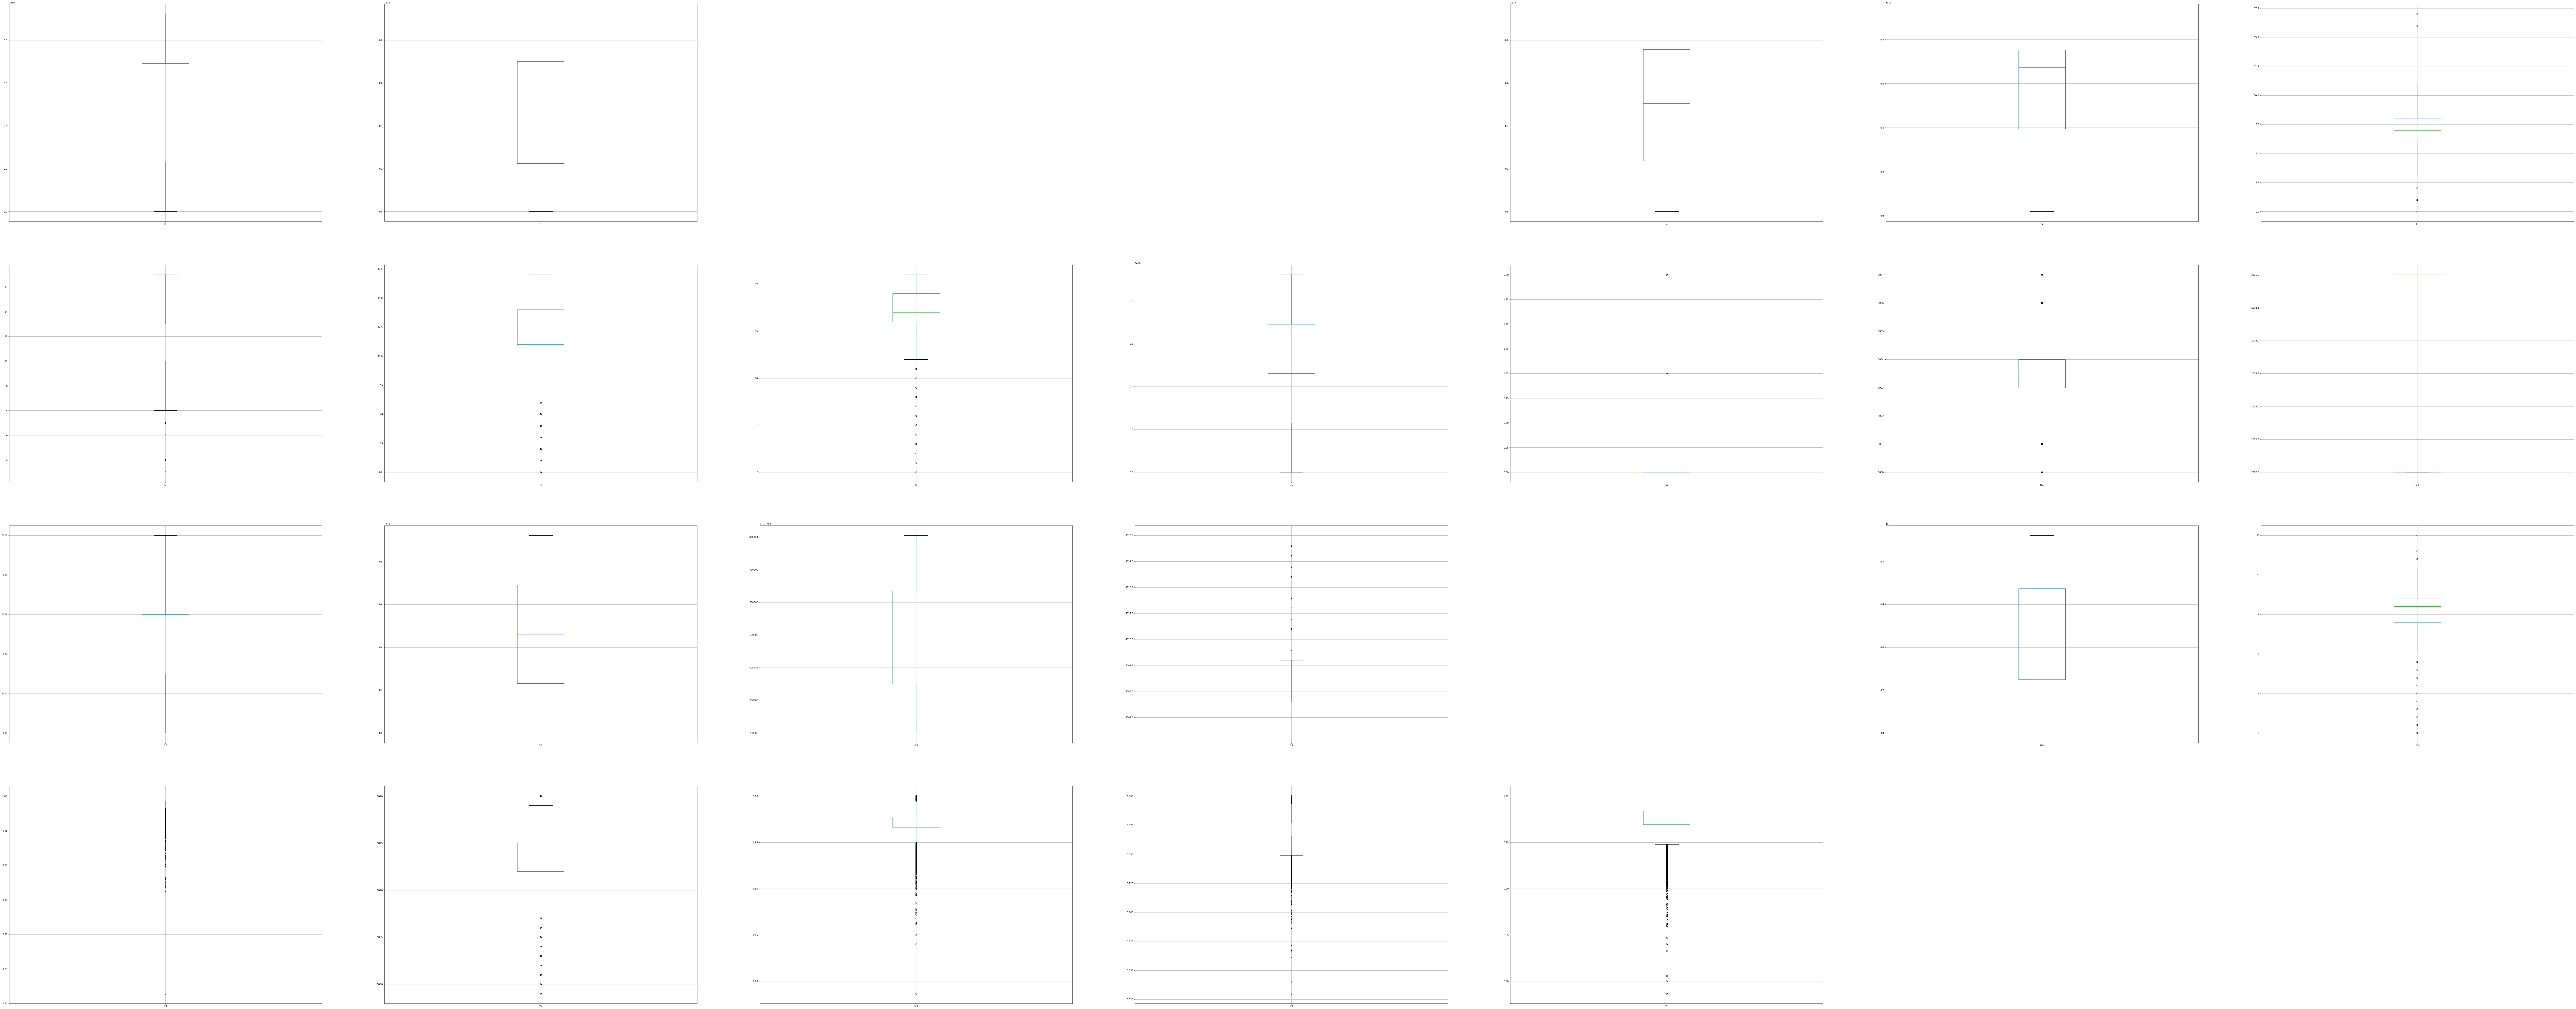

In [16]:
%matplotlib inline

fig = plt.figure(figsize = (200, 80))
for i in range(26):
    if(i == 2 or i == 3 or i == 18):
        continue
    plt.subplot(4,7,i + 1)
    data.boxplot(column = 'f' + str(i))
plt.show()

## 4.5热图（相关系数矩阵）

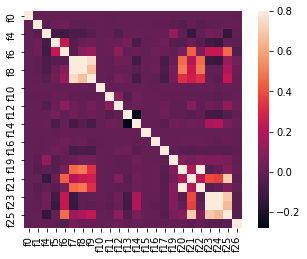

In [7]:
%matplotlib inline

corrmat = data.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax=.8, square=True);

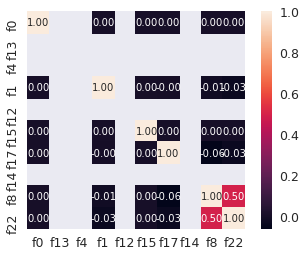

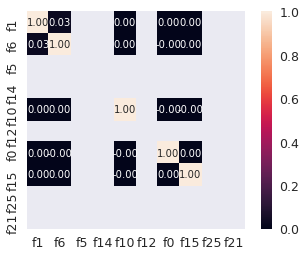

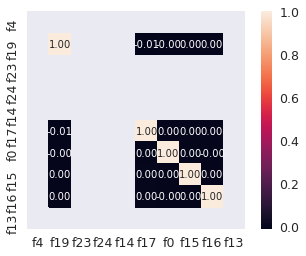

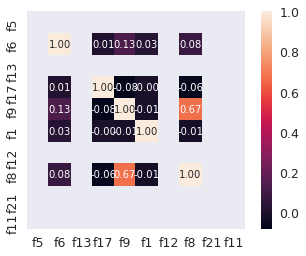

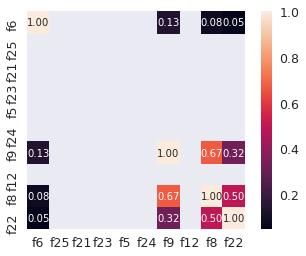

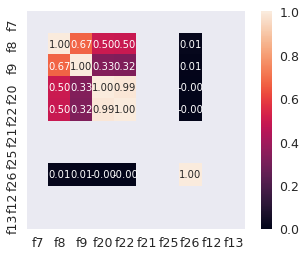

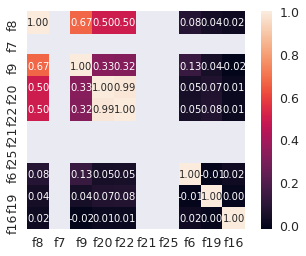

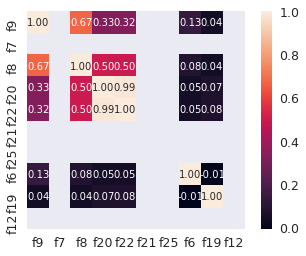

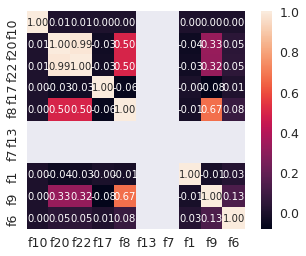

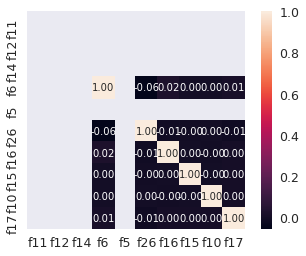

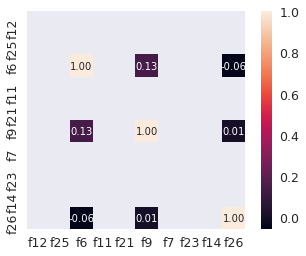

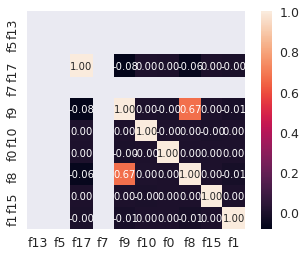

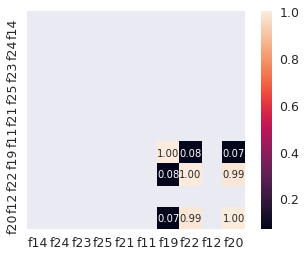

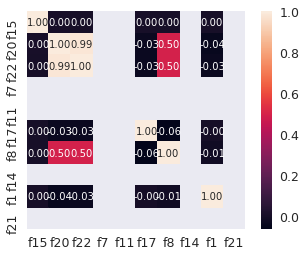

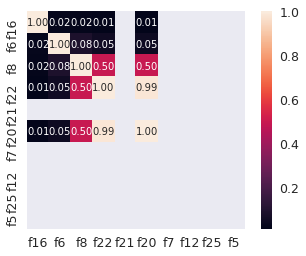

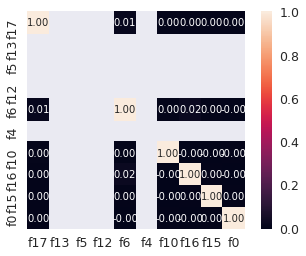

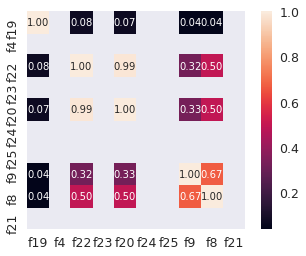

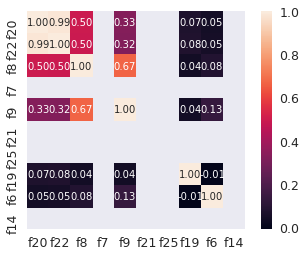

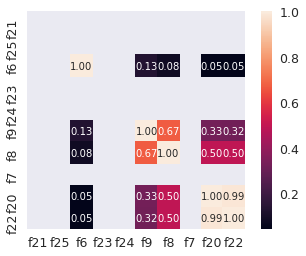

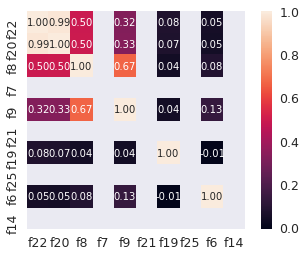

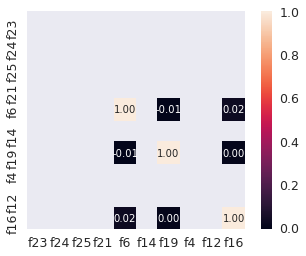

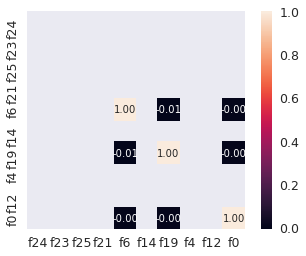

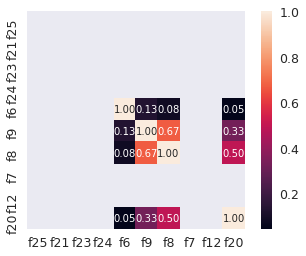

In [19]:
# 选取与各个特征相关系数最高的10个特征作热图，显示相关系数
k = 10 #number of variables for heatmap
for i in range(26):
    if(i == 2 or i == 3 or i == 18):
        continue
    cols = corrmat.nlargest(k, 'f' + str(i))['f' + str(i)].index
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

In [19]:
corrmat

,f0,f1,f4,f5,f6,f7,f8,f9,f10,f11,...,f16,f17,f19,f20,f21,f22,f23,f24,f25,f26
f0,1.000000,0.001380,0.001495,0.000025,-0.000380,-0.000177,0.000170,-0.001383,-0.000244,-0.002775,...,-0.001421,0.000568,-0.000115,-0.000014,-0.001696,0.000105,-0.001029,-0.001362,-0.001323,-0.002158
f1,0.001380,1.000000,-0.025813,0.018287,0.026952,-0.014469,-0.013726,-0.009804,0.002199,-0.003609,...,-0.004882,-0.002029,-0.021937,-0.038750,0.000688,-0.031353,-0.012064,-0.006458,0.001085,-0.000168
f4,0.001495,-0.025813,1.000000,-0.085620,-0.100276,-0.065450,-0.062514,-0.035005,-0.001108,-0.003037,...,-0.000665,0.005171,0.124105,-0.011710,-0.125404,-0.006977,0.036050,0.024399,-0.135034,-0.005320
f5,0.000025,0.018287,-0.085620,1.000000,0.242948,-0.031370,0.010932,0.019248,0.000603,0.007633,...,0.004708,0.024948,-0.043026,-0.041068,0.010078,-0.029444,-0.094015,-0.118748,-0.009968,-0.014822
f6,-0.000380,0.026952,-0.100276,0.242948,1.000000,-0.032255,0.083133,0.134814,0.001559,0.009639,...,0.023965,0.011926,-0.008429,0.045727,0.440206,0.048414,0.244492,0.242179,0.465866,-0.055895
f7,-0.000177,-0.014469,-0.065450,-0.031370,-0.032255,1.000000,0.857139,0.756179,0.003466,-0.003470,...,0.007546,-0.080973,0.013293,0.465379,0.203604,0.460831,-0.113362,-0.123955,0.134358,0.037127
f8,0.000170,-0.013726,-0.062514,0.010932,0.083133,0.857139,1.000000,0.672120,0.003792,-0.009483,...,0.017122,-0.063102,0.039910,0.496431,0.252632,0.495634,-0.010469,-0.017425,0.185040,0.013972
f9,-0.001383,-0.009804,-0.035005,0.019248,0.134814,0.756179,0.672120,1.000000,0.001850,-0.013764,...,-0.017674,-0.080865,0.042454,0.328187,0.272366,0.322467,-0.006551,-0.022796,0.244522,0.006077
f10,-0.000244,0.002199,-0.001108,0.000603,0.001559,0.003466,0.003792,0.001850,1.000000,-0.000437,...,-0.004256,0.004036,-0.001657,0.005374,-0.000419,0.005321,-0.001463,-0.002105,-0.001841,0.000255
f11,-0.002775,-0.003609,-0.003037,0.007633,0.009639,-0.003470,-0.009483,-0.013764,-0.000437,1.000000,...,0.002531,-0.002227,-0.003859,-0.006394,-0.002813,-0.006560,-0.018347,-0.020076,-0.004960,0.006542


- f0:f13 f12 f14 f4 f1 f15 f17 f23 f8
- f1:f1 f6 f5 f10 f21 f14 f12 f13 f0 f15
- f4:f4 f19 f23 f24 f17 f0 f14 f13 f15 f16
- f5:f5 f6 f17 f9 f1 f8 f21 f16 f11 f10
- f6:f6 f21 f5 f25 f9 f23 f24 f8 f22 f20
- f7:f7 f8 f9 f20 f22 f21 f25 f26 f19 f16
- f8:f8 f7 f9 f20 f22 f21 f25 f6 f19 f23
- f9:f9 f7 f8 f20 f22 f21 f25 f6 f19 f23
- f10:f10 f20 f22 f17 f8 f7 f1 f9 f6 f13
- f11:f11 f12 f14 f13 f26 f6 f16 f5 f15 f21
- f12:f12 f13 f14 f11 f24 f23 f20 f22 f25 f8
- f13:f13 f14 f12 f11 f24 f23 f20 f22 f8 f25
- f14:f14 f13 f12 f11 f24 f22 f20 f8 f25
- f15:f15 f20 f22 f11 f7 f17 f8 f1 f9 f0
- f16:f16 f6 f8 f22 f7 f20 f21 f5 f25 f11
- f17:f17 f5 f6 f4 f10 f16 f15 f0 f1 f12
- f19:f19 f4 f22 f20 f9 f8 f21 f23 f24 f25
- f20:f20 f22 f8 f7 f9 f21 f19 f25 f6 f24
- f21:f21 f25 f6 f23 f24 f9 f8 f7 f20 f22
- f22:f22 f20 f8 f7 f9 f21 f19 f25 f6 f24
- f23:f23 f24 f25 f21 f6 f8 f9 f19 f22 f20
- f24:f24 f23 f25 f21 f6 f22 f8 f20 f19 f9
- f25:f25 f23 f24 f21 f6 f9 f8 f7 f20 f22
- f26:f26 f7 f8 f11 f9 f12 f14 f13 f10 f1 f22 f20 f19 f15 f4 f16 f17 f5 f23 f24 f25 f21 f6

In [21]:
for i in [6,7,8,9,11,12,13,14,17,20,22]:
    print(data[['f' + str(i),'f26']].groupby(['f' + str(i)],as_index=False).mean().sort_values(by='f26', ascending=False))
    print()

    f6       f26
0    0  0.083333
1    1  0.058824
4    4  0.049702
2    2  0.048991
3    3  0.047672
5    5  0.030933
6    6  0.023142
7    7  0.015223
8    8  0.013436
9    9  0.007683
10  10  0.000000
11  11  0.000000
12  16  0.000000
13  17  0.000000

      f7       f26
14  15.0  0.032434
15  16.0  0.031903
13  14.0  0.025604
12  13.0  0.022374
11  12.0  0.019365
10  11.0  0.017727
9   10.0  0.015191
16  17.0  0.014322
7    8.0  0.013497
8    9.0  0.013421
6    7.0  0.012646
2    3.0  0.010846
5    6.0  0.010332
4    5.0  0.010106
0    1.0  0.009980
3    4.0  0.006811
1    2.0  0.005263

    f8       f26
17  17  0.025924
15  15  0.022560
14  14  0.020360
2    2  0.020325
16  16  0.020144
10  10  0.018928
12  12  0.018309
11  11  0.018034
9    9  0.017876
13  13  0.017847
6    6  0.017684
8    8  0.014474
7    7  0.012742
5    5  0.012126
4    4  0.011521
3    3  0.010650
1    1  0.007491
0    0  0.007168

    f9       f26
3    3  0.090909
21  21  0.025641
20  20  0.021632
10  10  0

- f6广告商品的价格等级（数值越大表示价格越高）：越便宜越容易买，价格等级为4时是容易被接受的一个中间值。
- f7广告商品的销量等级（数值越大表示销量越高）：销量越高越容易买，但是太高（如：17）会引起疑虑
- f8广告商品被收藏次数的等级（数值越大表示被收藏次数越高）：收藏越多越容易买，但是太低（如：2）也会容易买
- f9广告商品被展示次数的等级（数值越大表示被展示次数越大）：次数越高越容易买，但是一般展示3次就可以了。

- f11用户的预测性别编号：女性用户>家庭用户=男性用户
- f12用户的预测年龄等级（数值越大表示年龄越大）：中年人1005容易买，其次年龄越大越容易买（什么鬼）。
- f13用户的预测职业编号：
- f14用户的星级编号（越大星级越高）：

- f17广告商品的展示页面编号：越靠前越容易买，但也有一个容易被接受的中间值。

- f20店铺的评价数量等级（越大越高）：
- f22店铺的星级编号（越大越高）

## 4.6 特征与样本编号之间的关系

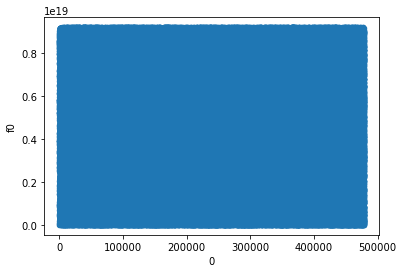

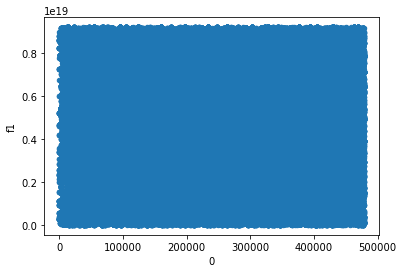

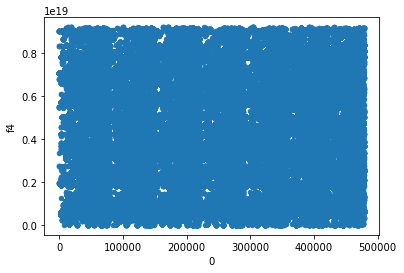

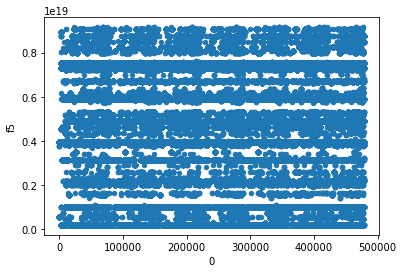

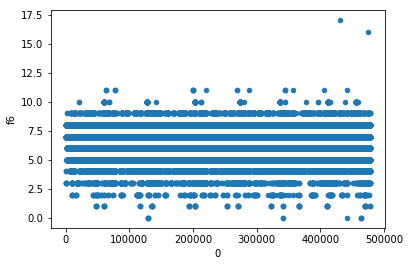

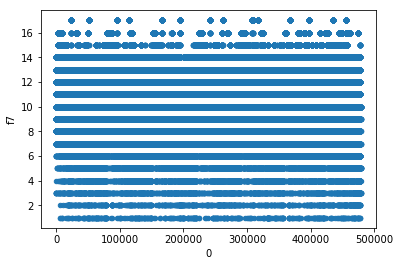

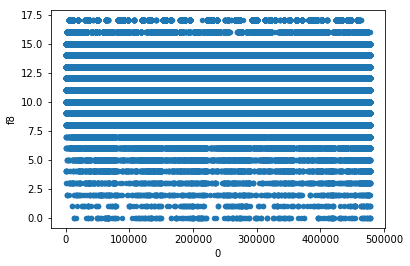

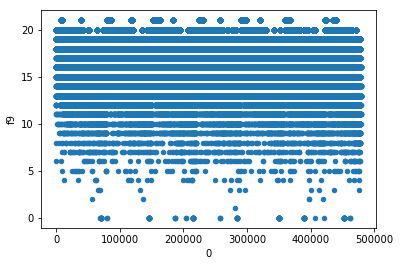

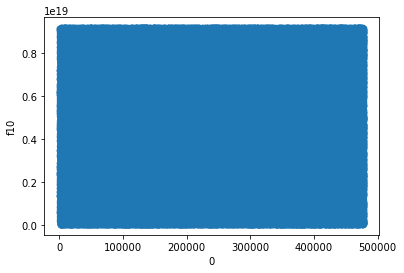

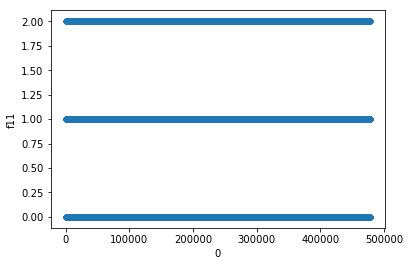

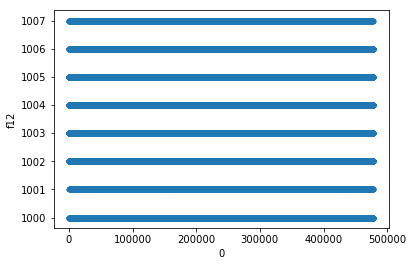

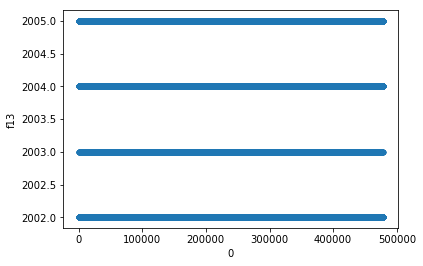

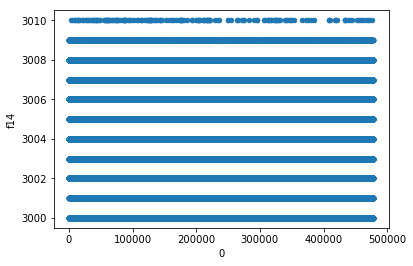

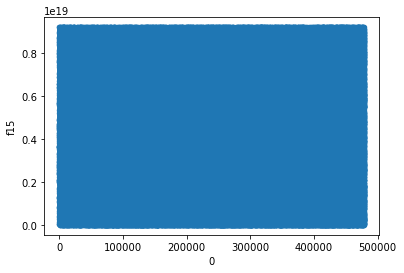

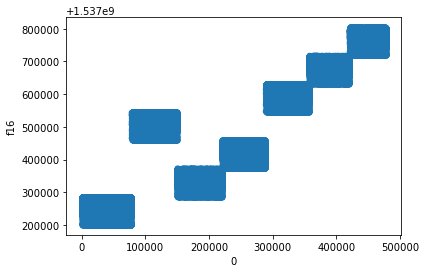

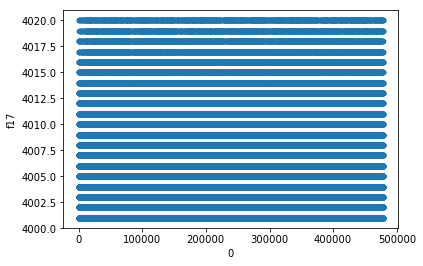

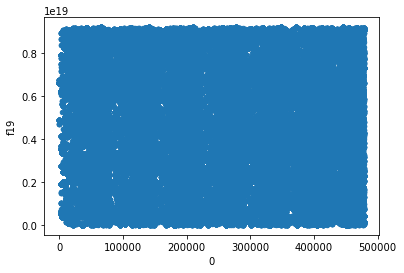

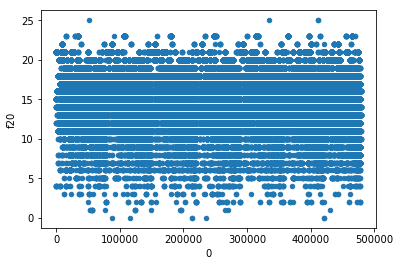

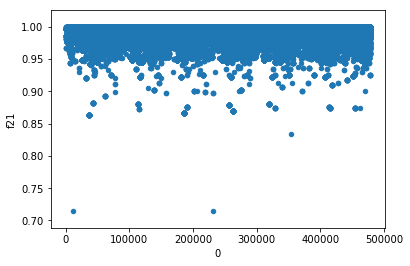

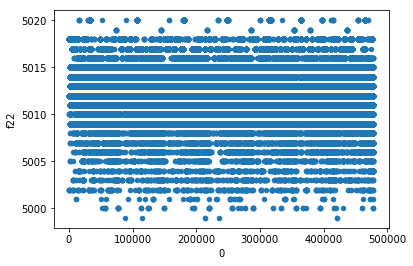

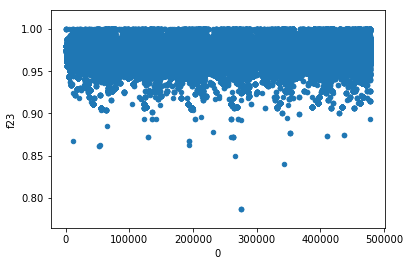

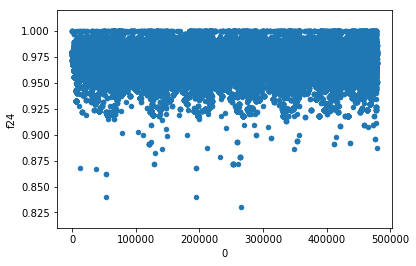

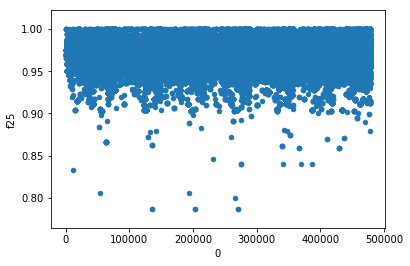

In [66]:
for i in range(26):
    if(i == 2 or i == 3 or i == 18):
        continue
    data_now = pd.concat([pd.Series(range(1,len(data['f' + str(i)]) + 1)),data['f' + str(i)]], axis=1)
#     print(data_now.columns)
    data_now.plot.scatter(x = 0, y= 'f' + str(i))

# 5.缺失值统计

In [50]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
f11,12902,0.026984
f13,964,0.002016
f14,964,0.002016
f12,964,0.002016
f7,913,0.001909
f4,473,0.000989
f5,277,0.000579
f25,59,0.000123
f23,59,0.000123
f24,59,0.000123


# 6.离散特征的取值统计

In [48]:
for i in range(26):
    if(i == 2 or i == 3 or i == 18):
        continue
    print(data['f' + str(i)].value_counts())

5479907258807096112    3
3370133319712542740    3
2535273059737073357    2
4984307821968110563    2
6031880284089240838    2
251764820957840061     2
2820033257616039272    2
833314485724646554     2
3779422444610157507    2
2247966536605008332    2
4716737653711059052    2
5547571229532052578    2
8495813758894672234    2
683023144061510567     2
5734962558666346526    2
8042010293411636231    2
6214707899917303043    2
6678029068572439929    2
644690756602987584     2
6020113693432894079    2
7773970221732336968    2
4713809052247380232    2
191012710137081307     2
6484429841255256717    2
6524018179115275803    2
1037061371711078396    2
7983370106370683357    2
7448305858307931414    2
7997153237845815308    2
6344363116315363445    2
                      ..
1204011044917236229    1
7234190422928073251    1
569893601106372361     1
7686108008974358413    1
2133180959478018283    1
3059489617484100694    1
550115284613514563     1
4500579299644989471    1
722076614882461939     1


1.000000    265926
0.997040      1852
0.997047      1727
0.997043      1691
0.997045      1548
0.997042      1536
0.997042      1521
0.997038      1403
0.995247       775
0.995260       626
0.995561       614
0.995248       603
0.995253       598
0.995257       591
0.995250       529
0.995554       519
0.976441       513
0.976399       502
0.995266       494
0.995557       480
0.995559       469
0.995551       462
0.976401       459
0.976484       444
0.976389       434
0.995545       414
0.995551       395
0.990360       379
0.998660       378
0.976371       372
             ...  
0.978226         1
0.993644         1
0.993266         1
0.988046         1
0.990995         1
0.962359         1
0.990161         1
0.957521         1
0.990906         1
0.994026         1
0.988514         1
0.989331         1
0.989009         1
0.982180         1
0.991117         1
0.989220         1
0.994260         1
0.991341         1
0.992108         1
0.988116         1
0.993537         1
0.981337    

# 7.离群点统计

In [ ]:
# 首先用标准化（标准化不会改变数据相对分布的特性）把数据转变成正态分布，分别查看最大和最小的十个值
for i in range(26):
    saleprice_scaled = StandardScaler().fit_transform(data['f' + str(i)][:,np.newaxis]);
    low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
    high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
    print('outer range (low) of the distribution:')
    print(low_range)
    print('\nouter range (high) of the distribution:')
    print(high_range)

# 8.是否符合独立同分布

# 9.时间对购买的影响

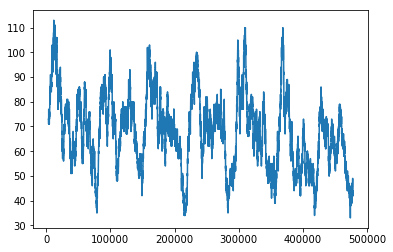

In [8]:
pd.rolling_sum(data['f26'],window = 3600).plot()

# 10.测试集和训练集的重合数据数

In [ ]:
# 特殊处理f2
data_test = pd.concat([data_test.loc[:,'f0':'f1'],data_test['f2'].astype(np.str).str.split(';', expand=True),data_test.loc[:,'f3':'f25']], axis = 1)

data_test.rename({0:'f2:1',1:'f2:2',2:'f2:3'}, axis='columns',inplace = True)

data_test['f2:3'].fillna('-1',inplace = True)
data_test['f2:1'] = data_test['f2:1'].astype('int')
data_test['f2:2'] =data_test['f2:2'].astype('int')
data_test['f2:3'] = data_test['f2:3'].astype('int')

In [151]:
dict(data['f19'].value_counts())

{6597981382309269962: 11278,
 1932086538588242822: 9702,
 8953967780295706657: 8353,
 2025576994711098052: 5172,
 4215742678121737516: 4296,
 4300400395541925383: 4216,
 5813143468854095050: 3727,
 4954894036019286224: 3418,
 5965128262672848132: 3353,
 4413707559864701260: 3097,
 2627012288522490757: 3001,
 8860698437199963449: 2990,
 8767852016880076521: 2833,
 572084226203388679: 2827,
 3727749929159444966: 2663,
 5407421979705782959: 2542,
 4350922866903977793: 2288,
 8175708238941346591: 2134,
 4470149128249776749: 2061,
 4084600578201061707: 2010,
 8242679862152043967: 1973,
 4142178404332280874: 1913,
 8182918076131034481: 1912,
 1267129908466668241: 1908,
 6732101033538972959: 1866,
 3608675879312967323: 1807,
 2555706603433129902: 1803,
 6134355454982746619: 1777,
 4995270795906434484: 1761,
 7305381580495918692: 1759,
 1091499661419284880: 1758,
 6673416224428620534: 1754,
 9182483786109216327: 1752,
 6844712265819528409: 1724,
 7256366555796349764: 1699,
 3476476589002967759

In [9]:
dic = {}
for nums in data['f3']:
    for num in nums.split(';'):
        if num not in dic:
            dic[num] = 1
        else:
            dic[num] += 1

In [11]:
len(dic)

61407

In [15]:
count1 = 0
for nums in data_test['f3']:
    for num in nums.split(';'):
        if(num not in dic):
            print(num)
        else:
            count1 += 1

5702065294177381258
831523512435130353
831523512435130353
831523512435130353
831523512435130353
7596149210471248515
8015075778250390823
5844549558662981411
2154278251005723620
1340261782069694532
6822473208659411372
9085007030922128690
1060974838807000075
1388931409154482809
1936630191892040004
53360147317845415
685296515447972699
8353569527786908485
5252678345678104591
355524183190489719
3426156838933328252
8633624598751270123
1718444844059315853
3518085894598835310
1738631574257496451
4934479953558203288
5502224159896540252
3810970268373901613
4715365664640768665
3810970268373901613
4715365664640768665
3810970268373901613
4715365664640768665
2186103699984732297
3594009579121186292
9116735801901642735
640494563967493555
659870272549462911
184094399909280479
5870650258356037442
6837288297397589171
2314268645289350398
2314268645289350398
7809518454126358561
283140000117907567
1487823528262358100
3214803764565087994
8271932833925503160
2407135259037998952
5360540721708050552
452562465490

923003428633500237
4016109621353476794
1985250607280714747
6954098413088787809
8152127076446753271
5832957944449308560
5280267569987610135
901891123701488941
4007846435173828735
510588463285964389
6477563211524647630
8942301253544237204
2011285450479026196
5787061225789197216
2296638212167954436
5294317572310122013
2836178460026389756
8233789801977668171
466113821231618667
1147361480166601954
4082136385176386272
5593631008657521526
1571044742849555638
7373443056243331276
923003428633500237
4016109621353476794
1985250607280714747
6954098413088787809
8152127076446753271
5832957944449308560
5280267569987610135
901891123701488941
4007846435173828735
510588463285964389
3725766457806294396
506567605231879667
8927270180991624133
1727848178045180080
8927270180991624133
1727848178045180080
8927270180991624133
1727848178045180080
8927270180991624133
1727848178045180080
8927270180991624133
1727848178045180080
8927270180991624133
1727848178045180080
502300048336417988
8748798186643846262
535118313

In [16]:
print(count1)
print(len(data_test))

631106
18371


# 11.f18的取值数

In [50]:
dic1 = {}
dic2 = {}
for item in data['f18']:
    try:
        for category in item.split(';'):
        
            now = category.split(':')
            if now[0] in dic1:    
                dic1[now[0]] += 1
            else:
                dic1[now[0]] = 1
        
            temp = now[1]
            summ += len(temp.split(','))
#             if(len(temp.split(',')) in dic2):
#                 dic2[len(temp.split(','))] += 1
#             else:
#                 dic2[len(temp.split(','))] = 1
#             for Property in temp.split(','):
#                 if Property in dic2:    
#                     dic2[Property] += 1
#                 else:
#                     dic2[Property] = 1
        if len(item.split(';')) in dic2:
            dic2[len(item.split(';'))] += 1
        else:
            dic2[len(item.split(';'))] = 1
    except:
        print(item)

nan
nan
nan
nan


In [51]:
dic2

{1: 1512,
 2: 48734,
 3: 69408,
 4: 98158,
 5: 97265,
 6: 78767,
 7: 51378,
 8: 18368,
 9: 10354,
 10: 4003,
 11: 137,
 12: 31,
 13: 18,
 14: 1}

# *.特征分析
## *.1样本编号
- 对用户购买倾向无用，仅作区分作用；与其他特征也没啥相关性（最大相关性0.0027）
- 每条数据一个样本编号，本来应该无重复，但是发现有重复，总体样本去重复后还有24个重复项，wtf？
- 样本编号竟然不是随着时间而递增的，似乎毫无关联，wtf？
- **产品的 ID 对预测相关度很有帮助，但是考虑训练集和测试集之间的重叠度，如果并不太高，利用它会不会导致 Overfitting？**

- 暂不考虑，删除特征。

## *.2.广告商品信息
### *.2.1广告商品编号
- 没啥相关；有大量重复，其实只有10075个商品。
- 暂时不考虑，删除特征。

### *.2.2广告商品的的类目列表（有从属关系）
- 暂不考虑

### *.2.3广告商品的属性列表（无从属关系）
- 暂不考虑


### *.2.4广告商品的品牌编号
- 与店铺编号（0.124105）正相关，推测店铺编号是品牌编号的子集。与店铺的描述相符评分（-0.135034）、店铺的好评率（-0.125404）、广告商品的价格等级（-0.1）负相关。
- 暂时不考虑，删除特征。

### *.2.5广告商品的城市编号
- 分布有点偏；与广告商品的价格等级（0.242948）成正相关；与店铺的物流服务评分（-0.118748）成负相关，推测城市编号越大越是偏远地区。
- 矫正分布

### *.2.6广告商品的价格等级（数值越大表示价格越高）
- 分布有点偏，符合正态分布；符合越便宜越容易买，价格等级为4时是容易被接受的一个中间值。
- 与**店铺的描述相符评分（0.47）、店铺的好评率（0.44）**、店铺的服务态度评分（0.24）、店铺的物流服务评分（0.24）、广告商品的城市编号（0.24）、广告商品被展示次数的等级（0.13）正相关；与广告商品的品牌编号负相关（-0.1）。
- 矫正分布；删除特征；将10（456）、2（347）、1（85）、11（21）、0（12）、17（1）、16（1）这几个取值单独拉出一个类。

### *.2.7广告商品的销量等级（数值越大表示销量越高）
- 分布有点偏，符合正态分布；销量越高越容易买，但是太高（如：17）会引起疑虑；与**广告商品被收藏次数的等级（0.86）、广告商品被展示次数的等级（0.76）、店铺的评价数量等级（0.47）、店铺的星级编号（0.46）**、店铺的好评率（0.20）、店铺的描述相符评分（0.13）正相关；与店铺的物流服务评分（-0.12）、店铺的服务态度评分（-0.11）负相关。
- 矫正分布；删除特征

### *.2.8广告商品被收藏次数的等级（数值越大表示被收藏次数越高）
- 分布有点偏，符合正态分布；收藏越多越容易买，但是太低（如：2）也会容易买；与**广告商品的销量等级（0.86）、广告商品被展示次数的等级（0.67）、广告商品被展示次数的等级（0.50）、店铺的星级编号（0.50）**、店铺的星级编号（0.25）、店铺的描述相符评分正相关（0.19）。
- 矫正分布；删除特征

### *.2.9广告商品被展示次数的等级（数值越大表示被展示次数越大）
- 分布有点偏，符合正态分布；可能与结果有线性关系；次数越高越容易买，但是一般展示3次就可以了；与**广告商品的销量等级（0.76）、广告商品被收藏次数的等级（0.67）**、店铺的评价数量等级（0.33）、店铺的星级编号（0.32）、店铺的好评率（0.27）、店铺的描述相符评分（0.25）、广告商品的价格等级（0.13）正相关；
- 矫正分布；删除特征；将8（449）、7（245）、0（123）、6（116）、5（63）、4（33）3（11）2（5）、1（1）这几个取值单独拉出一个类。

# *.3.用户
### *.3.1用户编号
- 对用户购买倾向无用，仅作区分作用；有三分之二的重复，真实只有197694用户在买东西。
- 暂时不考虑，删除特征。

### *.3.2用户的预测性别编号
- 0、1、2三个值；购买可能性：女性用户>家庭用户=男性用户。
- one-hot表示，扩充为4个特征，-1代表另一个类/随机预测；平衡男女比例？

### *.3.3用户的年龄等级
- 分布有点偏，符合正态分布；1000-1007共8个值，我猜是每10岁1个值；与店铺的描述相符评分（0.11）、广告商品的价格等级（0.1）；中年人1005容易买，其次年龄越大越容易买（什么鬼）。
- one-hot表示，扩充为10个特征  OR 用0-10代表；矫正分布。

### *.3.4用户的预测职业编号
- 2002-2005共4个值；与用户的星级编号成负相关。
- one-hot表示，扩充为4个特征  OR 用2-5代表。

### *.3.5用户的星级编号
- 3000-3010共11个值；与用户的预测职业编号（0.20）、店铺的服务态度评分正相关（0.18）；与用户的预测职业编号负相关（-0.28）。
- one-hot表示，扩充为11个特征  OR 用0-10代表；矫正分布。

## *.4.上下文信息
## *.4.1上下文信息编号
- 对用户购买倾向无用，仅作区分作用；无重复。
- 暂时不考虑，删除特征。。

### *.4.2广告商品的展示时间（单位：秒，Unix时间戳，以1天为单位对时间戳进行了偏移）
- 一共七天的数据：2018/9/18 0:0:1——2018/9/24 23:59:47
- 生成年、月、日、时、分、秒多个特征 OR 设定开始时间、偏移 OR 这是一年的第n天，这是一年的第n周，这是一周的第n天

### *.4.3广告商品的展示页面编号
- 4001-4020共20个页面；越靠前越容易买，但也有一个容易被接受的中间值。
- 用1-20代表

### *.4.4根据查询词预测的类目属性列表
## *.5.店铺
### *.5.1店铺编号
- 对用户购买倾向无用，仅作区分作用；与广告商品的品牌编号（0.124）正相关；大量重复，其实只有3959个店铺。
- 缩放映射到一个区间去。

### *.5.2店铺的评价数量等级（越大越高）
- 范围0-25；分布有点偏，符合正态分布；与**店铺的星级编号（0.986987）、广告商品被收藏次数的等级（0.50）、广告商品的销量等级（0.47）**、广告商品被展示次数的等级（0.33）、店铺的好评率（0.2）正相关。
- 矫正分布；删除特征；将23（353）、4（266）、2（87）、3（80）、1（20）、0（7）、25（4）这几个取值单独拉出一个类。

### *.5.3店铺的好评率（越大越高）
- 范围0.714286-1；分布有点偏，符合正态分布；与**店铺的描述相符评分（0.7）、广告商品的价格等级（0.44）**、店铺的服务态度评分（0.39）、店铺的物流服务评分（0.37）、广告商品被展示次数的等级（0.27）、广告商品被收藏次数的等级（0.25）、广告商品的销量等级（0.2）、店铺的评价数量等级（0.2）、店铺的星级编号（0.199）正相关；与广告商品的品牌编号（-0.13）反相关。
- 矫正分布；删除特征。 

### *.5.4店铺的星级编号（越大越高）
- 范围4999-5020；分布有点偏，符合正态分布；与**店铺的评价数量等级（0.99）、广告商品被收藏次数的等级（0.50）**、广告商品的销量等级（0.46）、广告商品被展示次数的等级（0.32）、店铺的好评率（0.20）正相关。
- 矫正分布；删除特征；用1-22代表；将5002（477）、5020（357）、5000（81）、5019（70）、5001（60）、4999（7）这几个取值单独拉出一个类。

### *.5.5店铺的服务态度评分（越大越高）
- 范围0.786667-1；分布有点偏，符合正态分布；与**店铺的物流服务评分（0.96）、店铺的描述相符评分（0.70）**、店铺的好评率（0.39）、广告商品的价格等级（0.24）、用户的星级编号（0.18）正相关；与广告商品的销量等级（-0.11）、广告商品的城市编号（-0.1）负相关。
- 矫正分布；删除特征。

### *.5.6店铺的物流服务评分（越大越高）
- 范围0.830000-1；分布有点偏，符合正态分布；与**店铺的服务态度评分（0.962362）、店铺的描述相符评分（0.660261）**、店铺的好评率（0.369526）、广告商品的价格等级（0.242179）、用户的星级编号（0.198627）正相关；与广告商品的销量等级（-0.12）、广告商品的城市编号（-0.11）、用户的预测职业编号（-0.1）负相关。
- 矫正分布；删除特征

### *.5.7店铺的描述相符评分（越大越高）
- 范围0.786667-1；分布有点偏，符合正态分布；与**店铺的好评率（0.714843）、店铺的服务态度评分（0.699349）、店铺的物流服务评分（0.660261）、广告商品的价格等级（0.465866）**、广告商品被展示次数的等级（0.244522）、广告商品被收藏次数的等级（0.18504）、广告商品的销量等级（0.134358）、广告商品的销量等级（0.114843）正相关；与广告商品的品牌编号（-0.13）成负相关。
- 矫正分布；删除特征。